In [494]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [495]:
class Id_creator:
    def __init__(self):
        self.last_id = -1
    def get_id(self):
        self.last_id +=1
        return self.last_id
    def __call__(self):
        return self.get_id()
    
    
    
class Graph_layers:
    def __init__(self):
        self._node_id_gen =  Id_creator()
        G = nx.Graph()
        G.add_nodes_from([(self._node_id_gen(), {'pos': (0,0),'type': 'e'})])
        self._layers=[G]
        
    def get_layer(self, i):
        return self._layers[i]
    
    def add_new_layer(self, G_new):
        self._layers.append(G_new)            
        
    def get_last_layer_index(self):
        return len(self._layers) - 1
    
    def display_i_layer(self, i):
        G_layer = self._layers[i]
        pos = nx.get_node_attributes(G_layer, 'pos')
        nx.draw_networkx(G_layer, pos)
        
    def get_node_id_gen(self):
        return self._node_id_gen

In [496]:
def p1(G, base_node_id, n_id_gen, side_len=2, max_random_offset = 0):
    assert(G.nodes[base_node_id]['type'].lower() == 'e' )
    assert(len(G.nodes)==1)
    all_new_nodes = []
    all_new_edges = []
    base_pos = G.nodes[base_node_id]['pos']
    x_offset = ((np.random.random()-0.5) * max_random_offset * 2)
    y_offset = ((np.random.random()-0.5) * max_random_offset * 2)
    i_node_x, i_node_y = base_pos[0], base_pos[1]
    i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I'})
    all_new_nodes.append(i_node)
    
    half_side_len = side_len/2
    e_nodes = [
        (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y + half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y + half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y - half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y - half_side_len),'type': 'e'})
    ]
    for i in range(len(e_nodes)):
        all_new_edges.extend([(e_nodes[i][0],e_nodes[i+1 if i + 1 < len(e_nodes) else 0][0])])
        all_new_edges.extend([(i_node[0],e_nodes[i][0])])
    
    all_new_nodes.extend(e_nodes)
    nG = nx.Graph()
    nG.add_nodes_from(all_new_nodes)
    nG.add_edges_from(all_new_edges)
    return nG, i_node


In [497]:
def conc_duplicates(G):
    org_nodes = list(G.nodes(data=True))

    org_nodes_dict = {}
    for node_id,data in org_nodes:
        try:
            org_nodes_dict[data['pos']].append(node_id)
        except KeyError:
            org_nodes_dict[data['pos']]=[node_id]

    nodes_to_replace = {} #keys nodes to be deleted, values nodes to replace them
    for key,ids in org_nodes_dict.items():
        if len(ids) > 1:
            for id_ in ids[1:]:
                nodes_to_replace[id_] = ids[0]
                
    for old_node, new_node in nodes_to_replace.items():
        neighbors = list(G.neighbors(old_node))
        for n in neighbors:
            G.remove_edge(old_node,n)
            G.add_edge(new_node,n)
        G.remove_node(old_node)
    return G

In [498]:
def avg_pos(pos1, pos2):
    return ((pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2)

def rm_edge_if_exists(G,n1id,n2id):
    try:
        G.remove_edge(n1id,n2id)
    except nx.NetworkXError:
        pass

#     e0 - - - e1
#      | \    / |
#      |   I0   |
#      | /   \  |
#     e2 - - - e3
#
#          |
#         \/
#
#     e0 - - - n0 - - - e1
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    n1 - - - n2 - - - n3
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2 - - - n4 - - - e3

def p2(G, base_node_id, n_id_gen):
    assert(G.nodes[base_node_id]['type'].lower() == 'i')
    es = list(G.neighbors(base_node_id))
    e0, e1, e2, e3 = None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])
    #prepare all new verticies accord to map above
    n0 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e1[1]['pos']),'type':'e'})
    n1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e2[1]['pos']),'type':'e'})
    n2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})
    n3 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e3[1]['pos']),'type':'e'})
    n4 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],e3[1]['pos']),'type':'e'})
    
    I1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],n2[1]['pos']),'type':'I'})
    I2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],n2[1]['pos']),'type':'I'})
    I3 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],n2[1]['pos']),'type':'I'})
    I4 = (n_id_gen(),{'pos' : avg_pos(e3[1]['pos'],n2[1]['pos']),'type':'I'})
    
    #remove not needed I point
    G.remove_node(base_node_id)
    #remove all connections that will be going through new nodes
    rm_edge_if_exists(G,e0[0],e1[0])
    rm_edge_if_exists(G,e1[0],e3[0])
    rm_edge_if_exists(G,e3[0],e2[0])
    rm_edge_if_exists(G,e2[0],e0[0])
    # add all new edges
    new_edges = [
        (e0[0],n0[0]),(n0[0],e1[0]),
        (e0[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],n1[0]),(n0[0],n2[0]),(e1[0],n3[0]),
        (n1[0],I1[0]),(n2[0],I1[0]), (n2[0],I2[0]),(n3[0],I2[0]),
        (n1[0],n2[0]),(n2[0],n3[0]),
        (n1[0],I3[0]),(n2[0],I3[0]), (n2[0],I4[0]),(n3[0],I4[0]),
        (n1[0],e2[0]),(n2[0],n4[0]),(n3[0],e3[0]),
        (e2[0],I3[0]),(n4[0],I3[0]), (n4[0],I4[0]),(e3[0],I4[0]),
        (e2[0],n4[0]),(n4[0],e3[0]),
    ]
    G.add_nodes_from([n0,n1,n2,n3,n4,I1,I2,I3,I4])
    G.add_edges_from(new_edges)
    conc_duplicates(G)


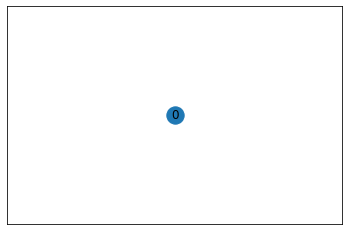

In [499]:
graph_layers = Graph_layers()
graph_layers.display_i_layer(0)

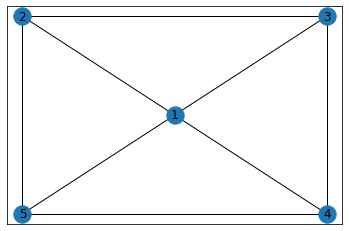

In [500]:
base_node = list(graph_layers.get_layer(0).nodes(data=True))[0]
#indexing from 0 
first_layer_G = graph_layers.get_layer(0).copy()

#apply p1 production
G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
graph_layers.add_new_layer(G)

graph_layers.display_i_layer(1)

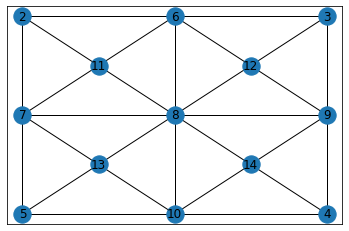

In [501]:
#apply p2 production
G = graph_layers.get_layer(1)
p2(G, 1, graph_layers.get_node_id_gen())


graph_layers.display_i_layer(1)

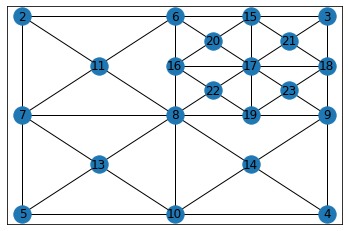

In [502]:
#apply p2 production
G = graph_layers.get_layer(1)
p2(G, 12, graph_layers.get_node_id_gen())

graph_layers.display_i_layer(1)

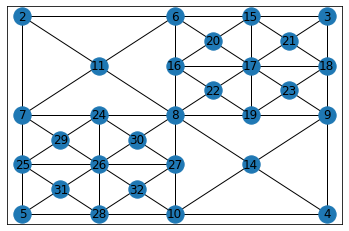

In [503]:
#apply p2 production
G = graph_layers.get_layer(1)
p2(G, 13, graph_layers.get_node_id_gen())

graph_layers.display_i_layer(1)

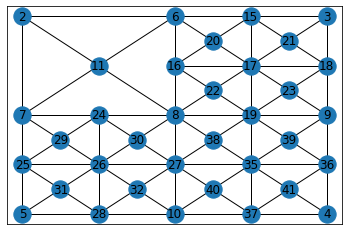

In [504]:
#apply p2 production
G = graph_layers.get_layer(1)
p2(G, 14, graph_layers.get_node_id_gen())

graph_layers.display_i_layer(1)